# TODO
- probability activation + cross entropy
- cross entropy weight
- focal loss
- Non Maximum Suppression

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import sklearn
from sklearn import metrics
import pydicom
from matplotlib.patches import Rectangle
from collections import namedtuple, defaultdict

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('/home/paperspace/data/pneumonia/toy')

In [4]:
BBox = namedtuple('BBox', 'x1 y1 x2 y2')

In [5]:
file2target = pd.read_csv(PATH/'train_targets.csv')
file2boxes = pd.read_csv(PATH/'train_rotated.csv')
file2boxes.set_index('patientId', inplace=True)
train_n = file2target.shape[0]
train_n

5000

In [6]:
def expand(str):
    while len(str.split() ) < 16:
        str = str+" 0 0 0 0"
    return str
file2boxes['bboxes']=file2boxes['bboxes'].apply(expand)
file2boxes.to_csv(PATH/'train_rotated.csv')

In [7]:
bbox_map = defaultdict(list)
for file_name ,row in file2boxes.iterrows():
    if not pd.isna(row['bboxes']):
        spl = row['bboxes'].split()
        for i in range(0,len(spl),4):
            box = BBox(int(spl[i]),int(spl[i+1]),int(spl[i+2]),int(spl[i+3]))
            bbox_map[file_name].append(box)

In [8]:
val_idxs = get_cv_idxs(train_n)
val_idxs.shape

(1000,)

In [9]:
bs  = 128
arch = resnet34
sz=128

In [59]:
class OverSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, counts):
        indices =[]
        for idx, cnt in enumerate(counts):
            indices = indices +[idx]*int(cnt)
        self.ind_arr = np.array(indices)
        np.random.shuffle(self.ind_arr)
    
    def __len__(self):
        return len(self.ind_arr)
    
    def __iter__(self):
        return iter(self.ind_arr)

In [76]:
def get_data(sz):
    augs = [RandomFlip(tfm_y=TfmType.COORD),
            RandomRotate(5, p=0.5,tfm_y=TfmType.COORD),
            RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]
    tfms = tfms_from_model(arch, sz, tfm_y=TfmType.COORD, aug_tfms=augs)
    data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train_rotated.csv',
                                    val_idxs=val_idxs, tfms=tfms,bs=bs,continuous=True)
    ''' train_ds = data.trn_ds
    train_dl = data.trn_dl
    all_y=np.ndarray(0)
    for x,y in train_dl.__iter__():
        all_y =np.append(all_y, y.cpu().numpy())

    weights = all_y*3 + 1
    sampler = OverSampler(weights)
    train_dl.sampler = sampler
    train_dl.batch_sampler=torch.utils.data.sampler.BatchSampler(sampler,bs,False)'''
    return data

In [11]:
def class_data(sz):
    tfms = tfms_from_model(arch, sz)
    data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train_targets.csv', val_idxs=val_idxs, tfms=tfms)
    return data

In [74]:
learner = ConvLearner.pretrained(arch, class_data(sz))

In [14]:
learner.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [77]:
data = get_data(sz)
md = data

In [13]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=1, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf)

In [18]:
'''class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
'''

'class OutConv(nn.Module):\n    def __init__(self, k, nin, bias):\n        super().__init__()\n        self.k = k\n        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)\n        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)\n        self.oconv1.bias.data.zero_().add_(bias)\n        \n    def forward(self, x):\n        return [flatten_conv(self.oconv1(x), self.k),\n                flatten_conv(self.oconv2(x), self.k)]\n'

In [14]:
# TODO: bias
class SSD_Head(nn.Module):
    def __init__(self):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,128)
        self.sconv1 = StdConv(128,64)
        self.sconv2 = StdConv(64,4, stride=1)
        
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        x = self.sconv2(x)
        return F.relu(flatten_conv(x))

In [16]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [17]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [18]:
def boxes2tens(boxes):
    return V(np.array(boxes), requires_grad=False).float()

In [19]:
grid_sz = 4
grid_p = np.linspace(0,sz,grid_sz+1)
anch_boxes = [BBox(grid_p[xi],grid_p[yi],grid_p[xi+1], grid_p[yi+1]) for xi in range(grid_sz) for yi in range(grid_sz)]
anch_centers = [((box.x2 + box.x1)/2, (box.y2+box.y1)/2) for box in anch_boxes]
anch_tensor =boxes2tens(anch_boxes)

In [209]:
def get_y(bbox):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()
    bb_keep = bb_keep[:,0]
    return bbox[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2] * grid_sizes) * 2 - grid_sizes + anchors[:,:2]
    actn_hw = 1.5*actn_bbs[:,2:] * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def avg_size(boxes):
    return ((boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1])).mean()

def ssd_1_loss(activ, tar_box):
    a_ic = actn_to_bb(activ, anchors)
    if len(tar_box.nonzero())==0:
        return V(0.), avg_size(a_ic)
    bbox = get_y(tar_box)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps)
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    #print(pos_idx)
    neg_idx = torch.nonzero(1-pos)[:,0]
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    neg = a_ic[neg_idx]
    neg_loss  = avg_size(neg)
    return loc_loss, neg_loss

def ssd_loss(pred,targ,print_it=False):
    lng,lls = 0.,0.
    for activ, tar_box in zip(pred,targ):
        loc_loss,neg_loss = ssd_1_loss(activ, tar_box)
        lls += loc_loss
        lng += neg_loss
    if print_it: print(f'loc: {lls.data[0]}, neg: {lng.data[0]}')
    return lls+lng

In [26]:
x,y = next(iter(data.val_dl))


In [207]:
act = learn.model(V(x))

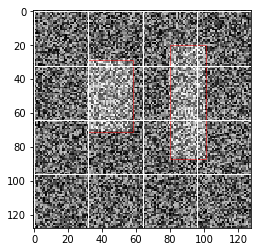

In [208]:
idx=14
activ0 = act[idx]
tar_box0 = V(y)[idx]

act_boxes =actn_to_bb(activ0, anchors)*128
act_boxes = act_boxes.cpu().data.numpy().reshape(-1)

filename = data.val_ds.fnames[idx]
ax =display(filename)
draw_boxes(ax, anch_boxes, color='white')
draw_rects(ax,act_boxes, 'blue')

In [137]:
ssd_1_loss(activ0, tar_box0)

(Variable containing:
 1.00000e-02 *
   2.6577
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 1.00000e-04 *
   9.5023
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [138]:
ssd_loss(act, V(y), True)

loc: 1.515782356262207, neg: 0.10044632107019424


Variable containing:
 1.6162
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [210]:
head_reg4 = SSD_Head()
models = ConvnetBuilder(arch, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit=ssd_loss

epoch      trn_loss   val_loss                            
    0      5.742547   7.213189  



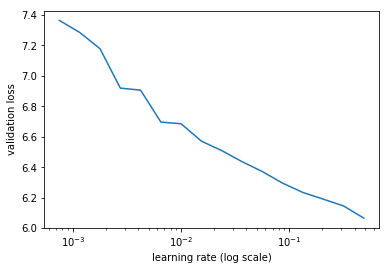

In [141]:
learn.lr_find()
learn.sched.plot()

In [212]:
learn.fit(1e-1, 3)

epoch      trn_loss   val_loss                            
    0      4.169788   5.45705   
    1      3.820496   3.189749                            
    2      3.645353   3.048077                            



[array([3.04808])]

In [211]:
learn.unfreeze()

In [213]:
learn.fit(1e-2, 3, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      3.388482   2.977148  
    1      3.417482   2.932109                            
    2      3.381963   2.918814                            
    3      3.366923   3.020723                            
    4      3.34578    2.964893                            
    5      3.260638   2.820294                            
    6      3.187648   2.78429                             



[array([2.78429])]

In [206]:
learn.fit(1e-3, 2, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      2.705361   2.234886  
    1      2.695976   2.136634                            
    2      2.686428   2.23484                             



[array([2.23484])]

In [31]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [32]:
def bb_hw(bb): return np.array([bb[1], bb[0], bb[3]-bb[1], bb[2]-bb[0]])

In [33]:
def draw_box(ax,box, color='red'):
    draw_rect(ax, list(box), color)
def draw_boxes(ax, boxes, color='red'):
    for box in boxes: draw_box(ax,box,color)

In [34]:
def draw_rect(ax, b, color='red'):
    patch = ax.add_patch(Rectangle(b[:2],*b[-2:], fill=False, edgecolor=color))

In [128]:
def draw_rects(ax, boxes, color='red'):
    for i in range(0,len(boxes),4):
        bbox = BBox(*boxes[i:i+4])
        ar = area(bbox)
        if(ar>1):
            draw_rect(ax,bb_hw(boxes[i:i+4]),color)

In [36]:
def display(file_name,ax=None):
    if ax is None:
        _,ax = plt.subplots(1,1)
    ax.imshow(PIL.Image.open(PATH/file_name))
    boxes =bbox_map[str(Path(file_name).name)]
    for box in boxes:
        x1,y1,w,h = bb_hw(box)
        ax.add_patch(Rectangle(xy=(x1,y1),width=w,height=h,alpha = 0.5, fill=False, color='red'))
    return ax

In [37]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

[BBox(x1=29, y1=32, x2=71, y2=58),
 BBox(x1=20, y1=80, x2=87, y2=101),
 BBox(x1=0, y1=0, x2=0, y2=0),
 BBox(x1=0, y1=0, x2=0, y2=0)]

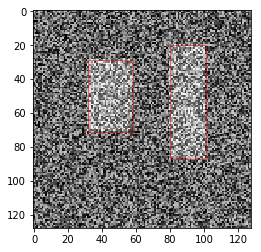

In [38]:
name0 = data.aug_dl.dataset.fnames[14]
display(name0)
bbox_map[Path(name0).name]

[29. 70. 71. 96. 20. 27. 87. 48.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 27.  32.  71.  60.  21.  78.  89. 104.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 29.  31.  71.  58.  19.  79.  87. 101.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 29.  32.  71.  58.  20.  80.  87. 101.   0.   0.   0.   0.   0.   0.   0.   0.]
[27. 68. 71. 96. 21. 25. 89. 49.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 29.  31.  72.  58.  19.  78.  86. 102.   0.   0.   0.   0.   0.   0.   0.   0.]
[27. 68. 71. 96. 21. 24. 90. 50.  0.  0.  0.  0.  0.  0.  0.  0.]
[29. 70. 71. 96. 20. 27. 87. 48.  0.  0.  0.  0.  0.  0.  0.  0.]
[27. 68. 71. 96. 21. 24. 89. 49.  0.  0.  0.  0.  0.  0.  0.  0.]


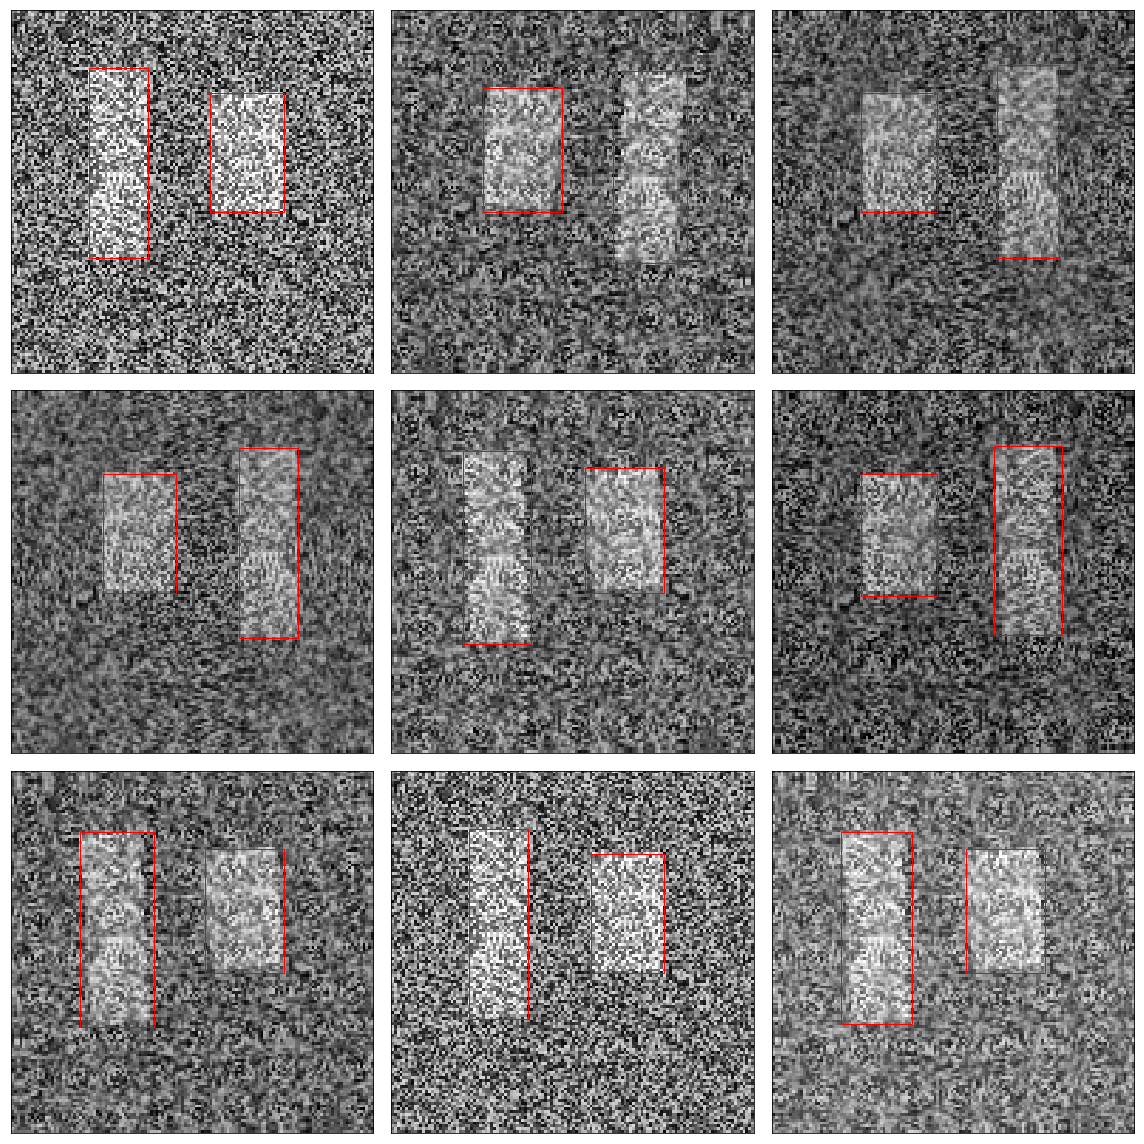

In [77]:
idx=14
fig,axes = plt.subplots(3,3, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(data.aug_dl))
    ima=data.val_ds.denorm(to_np(x))[idx]
    b = to_np(y[idx])
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, bb_hw(b[0:4]))
    draw_rect(ax, bb_hw(b[4:8]))
    draw_rect(ax, bb_hw(b[8:12]))
plt.tight_layout()

In [178]:
preds = learn.predict()
preds =[(actn_to_bb(V(p), anchors)*128).cpu().data.numpy().flatten() for p in preds]
preds

[array([  3.75257,  10.97757,  13.3387 ,  10.97757,   7.74616,  37.35131,  16.83784,  37.35131,   7.80641,
         74.23805,  19.40026,  74.23805,   8.54733,  97.92352,  19.48713,  97.92352,  47.7942 ,  22.03482,
         63.04344,  22.03482,  56.15384,  38.62698,  67.13867,  38.62698,  50.67388,  85.94744,  66.10082,
         85.94744,  44.99891,  98.45795,  65.13966, 100.29015,  61.08657,  22.96688,  83.2962 ,  28.23335,
         57.33395,  19.27039,  82.62029,  50.06546,  58.0913 ,  82.80709,  77.42839,  93.13848,  56.84563,
         91.80049,  77.18127, 104.9687 ,  92.37881,  18.75904, 101.4705 ,  18.75904,  92.37881,  33.92352,
        101.4705 ,  33.92352,  92.37881,  79.67598, 101.4705 ,  79.67598,  92.37881,  98.44881, 101.4705 ,
         98.44881], dtype=float32),
 array([  3.22483,  11.22278,  14.01576,  11.22278,   5.07249,  41.14983,  17.90813,  41.14983,   4.16591,
         75.02237,  17.95075,  75.02237,  -0.28334, 100.63045,  15.93906, 100.63045,  36.53668,  16.98747,
 

In [96]:
def show_prediction(img_data, pred, truth, ax):
    show_img(img_data,ax=ax)
    draw_rects(ax, truth)
    draw_rects(ax, pred, 'blue')

In [179]:
def area(b):
    if b.x1 >= b.x2 or b.y1 >= b.y2: return 0
    return (b.x2-b.x1)*(b.y2 - b.y1)
area(BBox(0,0,100,100))

def ar2boxes(b):
    res =[]
    for i in range(0,len(b),4):
        bint = [int(round(x)) for x in b[i:i+4]]
        box = BBox(*bint)
        if area(box) >1: res.append(box)
    return res


def IoU(b1, b2):
    ab1 = area(b1)
    ab2 = area(b2)
    if ab1 <1 or ab2 < 1: return 0
    inter = BBox(max(b1.x1,b2.x1), max(b1.y1,b2.y1), min(b1.x2,b2.x2), min(b1.y2,b2.y2))
    union = ab1+ab2-area(inter)
    return area(inter)/union

def score_tre(tresh, preds, actuals):
    pred_hits = np.full(len(preds), False)
    act_hits = np.full(len(actuals), False)
    for pi in range(len(preds)):
        for ai in range(len(actuals)):
            if pred_hits[pi] or act_hits[ai]: continue
            b1,b2 = preds[pi], actuals[ai]
            if IoU(b1,b2) >= tresh: pred_hits[pi]=act_hits[ai]=True
    tp = np.sum(pred_hits == True)
    fp = np.sum(pred_hits == False)
    fn = np.sum(act_hits == False)
    #print(tp,fp,fn)
    return tp / (tp+fp+fn)
p = [BBox(0,10,30,40)]; a= [BBox(10,10,40,40),BBox(40,40,50,50)]
score_tre(.1, p,a)

def score(preds, actuals):
    ret =0
    for thr in np.linspace(0.4,0.75,8):
        ret+= score_tre(thr, preds,actuals)
    return ret/8
p = [BBox(0,10,30,40)]; a= [BBox(10,10,40,40),BBox(40,40,50,50)]
score(p,a)    

def score_all(pred, truth):
    assert len(pred) == len(truth)
    sum = 0
    cnt = 0
    for idx in range(len(pred)):
        pred_box = ar2boxes(pred[idx])
        true_box = ar2boxes(truth[idx])
        if pred_box or true_box:
            sum += score(pred_box, true_box)
            cnt += 1
    return sum / cnt
score_all(preds, data.val_ds.y)

0.36353606296074914

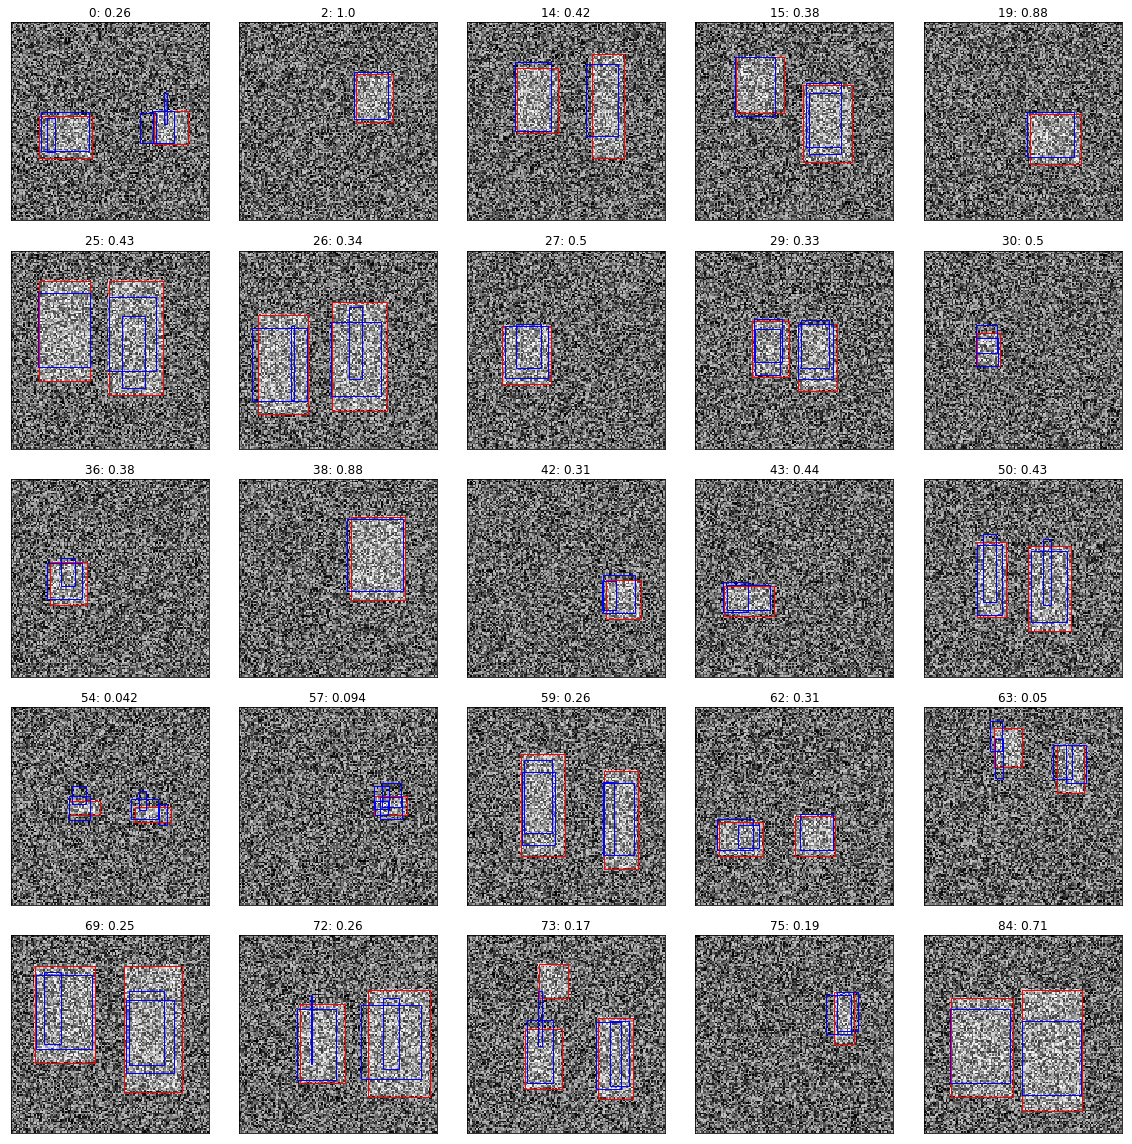

In [180]:
val_it = iter(data.val_dl)
x,y=next(val_it)
_,axs = plt.subplots(5,5,figsize=(16,16))
axs = axs.flatten()
idx=0
denx = data.val_ds.denorm(to_np(x))
y = to_np(y)
for ax in axs:
    while y[idx][0]==0 :idx +=1
    ima=denx[idx]
    #print(y[idx])
    #print(data.val_ds.y[idx])
    sc = score(ar2boxes(preds[idx]), ar2boxes(y[idx]))
    ax.set_title(f'{idx}: {sc:.2}')
    show_prediction(ima,preds[idx], y[idx], ax)
    idx+=1
plt.tight_layout()